# Mid eclipse timing and OC calculation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
from astropy.table import Table
from pathlib import Path
from astropy.coordinates import SkyCoord
from astroquery.mast import Catalogs
import pandas as pd
from astropy.table import vstack
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
import re
from glob import glob
from astropy.stats import sigma_clip
from PyAstronomy.pyTiming import pyPDM
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import correlate
from scipy.signal import medfilt
from PyAstronomy.pyTiming import pyPDM
from scipy.optimize import curve_fit
from statsmodels.nonparametric.smoothers_lowess import lowess
from joblib import Parallel, delayed
from tqdm import tqdm
import os
from scipy.optimize import least_squares

This notebook covers the method we used to find mid eclipse times for all eclipses within each lightcurve, and then compares them to when we expect to see an eclipse to generate an OC value. We can then plot these OC values to see the time evolution of the system's eclipses.

The first step is to read in the necessary data from the eclipse_models csv file alongside our lightcurves.

In [2]:
# Read in the data for future
df = pd.read_csv("Data/eclipse_models.csv")

# --- Flux arrays ---
primary_models = df.iloc[:, 0:400].to_numpy().tolist()
secondary_models = df.iloc[:, 400:800].to_numpy().tolist()

# --- Mid-eclipse times ---
primary_mets = df.iloc[:, 800].to_list()
secondary_mets = df.iloc[:, 801].to_list()

# --- Eclipse Widths --- 
primary_widths = df.iloc[:, 802].to_list()
secondary_widths = df.iloc[:, 803].to_list()

In [3]:
# Read in our lightcurves
lightcurves = []
files = glob("Data/combined_lightcurves/*.csv")

for f in files:
    lc = Table.read(f, format='csv')
    lightcurves.append(lc)  

Our next step is to create a list of windows that contain eclipses. To do this, we propagate our mid eclipse times back and forth based on the period of that eclipse. We then take some small range around the predicted mid eclipse time (a few eclipse widths) and define this as our window, or a small part of the lightcurve.

In [4]:
def generate_e_mets(met, period, time_array): # Creates a list of eMETS given a reference MET and a period

    t_min = np.min(time_array)
    t_max = np.max(time_array)
    mets = []

    n = 0
    while True:
        t = met + n * period
        if t > t_max:
            break
        mets.append(t)
        n += 1

    n = 1
    while True:
        t = met -  n * period
        if t < t_min:
            break
        mets.append(t)
        n += 1

    return sorted(mets)

In [5]:
def generate_window(lc, emet, width, factor=3):
    mask = (lc['time'] > emet - factor*width) & (lc['time'] < emet + factor*width)
    return lc[mask]  

In [6]:
# Initialise some empty lists
p_emets_list, s_emets_list = [], []

# Loop over our primary mets
for i, met in enumerate(primary_mets):
    lc = lightcurves[i]
    period = lc[0]['p_period']
    times = lc['time']
    e_mets = generate_e_mets(met, period, times)
    p_emets_list.append(e_mets)

# Loop over our secondary mets
for i, met in enumerate(secondary_mets):
    lc = lightcurves[i]
    period = lc[0]['s_period']
    times = lc['time']
    e_mets = generate_e_mets(met, period, times)
    s_emets_list.append(e_mets)

In [7]:
# Create slices of our lightcurve (windows) around expected eclipses
p_windows_list, s_windows_list = [], []

# Primaries
for i, p_emets in enumerate(p_emets_list):
    lc = lightcurves[i]
    width = primary_widths[i]
    window_list = []
    for p_emet in p_emets: # One window for each eclipse
        window = generate_window(lc, p_emet, width)
        window_list.append(window)
    p_windows_list.append(window_list)

# Secondaries
for i, s_emets in enumerate(s_emets_list):
    lc = lightcurves[i]
    width = secondary_widths[i]
    window_list = []
    for s_emet in s_emets:
        window = generate_window(lc, s_emet, width)
        window_list.append(window)
    s_windows_list.append(window_list)
            

Now that we have these windows, we want to find the eclipses within them, and try and precisely time them. The process to do this requires a few steps.

First we extend the model eclipse to cover the entire window by appending flux values of 1 on either side to represent the baseline flux level of that source. Then, we perform a cross correlation using a coarse and fine grid to get approximate timings for the eclipse. Following this cross correlation, a least squares optimisation is performed that gives more freedom to the eclipse shape by allowing the depth to change. Lastly, based on the results of the least squares optimisation, one more cross correlation over a short time is used to find a precise eclipse mid point as well as 1 sigma errorbars.

This process can take up to a few minutes per source, so I will only do one here, but it can be easily generalised to a list of sources.

In [13]:
def extend_model(window, model, model_time_axis): # extends the model to match the shape of the window

    # Interpolate the model
    dt = np.median(np.diff(model_time_axis))
    
    # Model length
    T_model = model_time_axis[-1] - model_time_axis[0]

    # Window length
    window_start_time = min(window['time'])
    window_end_time = max(window['time'])
    T_window = window_end_time - window_start_time
    
    buffer = 5 * dt  # small safety margin

    # To ensure the model completely covers the window even when we slide it
    T_needed = 2 * T_window  + buffer
    T_needed = max(T_needed, 0.0)  # just in case

    n_pad_total = int(np.ceil(T_needed / dt))
    n_pad_left = n_pad_total // 2
    n_pad_right = n_pad_total - n_pad_left

    # Pad the models with 1's
    model_extended = np.concatenate([np.ones(n_pad_left), model, np.ones(n_pad_right)])

    # Pad our time axis
    t_left = model_time_axis[0] - dt * np.arange(n_pad_left, 0, -1)
    t_right = model_time_axis[-1] + dt * np.arange(1, n_pad_right + 1)
    time_extended = np.concatenate([t_left, model_time_axis, t_right])
    
    return model_extended, time_extended

In [14]:
def cross_correlate(model_interp, window, window_width, coarse_cadence, fine_cadence, params=1):
        
    # Define the bounds of the window
    window_start_time = min(window['time'])
    window_end_time = max(window['time'])

    # Renormalise the window flux and flux error
    if len(window['flux']) > 50:
        window_flux = window['flux'] / np.nanmedian(window['flux'])
        window_flux_err = window['flux_err'] / np.nanmedian(window['flux'])
    else: # Safeguard against normalising out an eclipse if we have very small data amounts
        window_flux = window['flux']
        window_flux_err = window['flux_err']

    # List of offsets for our coarse search
    coarse_model_eval_times = np.arange(window_start_time - window_width, window_end_time, coarse_cadence)

    if len(coarse_model_eval_times) == 0: # Failsafe for low amounts of data
        return None, None

    # Perform the coarse grid search
    coarse_chisq = []

    for t in coarse_model_eval_times:
            
        model_at_data = model_interp(window['time'] - t)
    
        residuals = (window_flux - model_at_data) / window_flux_err
        chisq = np.sum(residuals**2)
        
        coarse_chisq.append(chisq)

    # Find the best fit from the coarse search
    best_chisq_idx = np.argmin(coarse_chisq)
    best_time = coarse_model_eval_times[best_chisq_idx]  

    # Create a fine grid of times
    fine_model_eval_times = np.arange(best_time - 3*coarse_cadence, best_time + 3*coarse_cadence, fine_cadence)

    # Perform a fine cross correlation for refinement
    fine_chisq = []

    for t in fine_model_eval_times:
    
        model_at_data = model_interp(window['time'] - t)
    
        residuals = (window_flux - model_at_data) / window_flux_err
        chisq = np.sum(residuals**2)
        
        fine_chisq.append(chisq)
        
    # Compare the fit metric (Chisq) against a flat fit 
    flat_model = np.ones_like(window_flux)
    chisq_flat = np.sum(((window_flux - flat_model) / window_flux_err)**2)
    
    dchisq_detect = chisq_flat - fine_chisq
    dchisq_error = fine_chisq - np.min(fine_chisq)

    # Calculate the best fitting time (NOT THE MET)
    best_fine_chisq_idx = np.argmin(fine_chisq)
    model_start_time = fine_model_eval_times[best_fine_chisq_idx]

    return model_start_time, dchisq_detect, dchisq_error, fine_model_eval_times

In [15]:
def get_t0_errors(model_interp, window, model_start_time, dt=10/60/24, ngrid=5000, plot=False):

    # Get time and flux values out
    time = np.array(window['time'])
    flux = np.array(window['flux'])
    flux_err = np.array(window['flux_err'])

    # Time grid centered on best-fit t0
    t0_grid = model_start_time + np.linspace(-dt, dt, ngrid)

    # Create a chisq grid
    chisq = np.zeros(len(t0_grid))

    # Calculate chisq values over a 5 min interval
    for i, t0 in enumerate(t0_grid):
        model_at_window = model_interp(time - t0)
        resid = (flux - model_at_window) / flux_err
        chisq[i] = np.sum(resid**2)

    # Calculate the best fitting time
    t0_best = t0_grid[np.argmin(chisq)]
    dchisq = chisq - np.min(chisq)

    # Look for 1 sigma errorbars
    mask = dchisq <= 1
    idx = np.where(mask)[0]

    if len(idx) == 0:
        return None, None, None

    left = t0_grid[idx[0]]
    right = t0_grid[idx[-1]]

    if plot:
        plt.plot(t0_grid, dchisq)
        plt.axvline(left, c = 'green', label = 'left')
        plt.axvline(right, c = 'black', label = 'right')
        plt.axvline(t0_best, c = 'red', ls = '--')
        plt.legend()
        plt.show()

    return t0_best,  t0_best - left, right - t0_best  

In [16]:
def too_noisy(window, threshold=9):
    flux = window['flux']
    flux_err = window['flux_err']

    flux_spread = np.nanpercentile(np.abs(np.diff(flux)), 90)

    if np.nanmedian(flux_err) * threshold < flux_spread:
        return True
    return False

In [17]:
def find_eclipse_optimise(window, width, model_flux, i, iw, coarse_cadence=5/60/24, fine_cadence=5/60/60/24, plot=True, eclipse='primary', refine=True, chisq_threshold=1000):

    # Filter out empty windows
    '''Breaks covariance matrices --> Changed to 3 from 0'''
    if len(window) < 3:
        return None, None, None, None

    # Check if we could detect an eclipse:
    '''New check to see if we are fitting to noise --> Risk now that we can change depth'''
    emet = [p_emets_list[i][iw] if eclipse == 'primary' else s_emets_list[i][iw]][0]
        
    if np.max(window['time']) < emet - width:
        return None, None, None, None

    if np.min(window['time']) > emet + width:
        return None, None, None, None

    # Check for windows that are more variable than expected
    noise_flag = too_noisy(window)
    if noise_flag == True:
        return None, None, None, None
    
    # Define a time axis
    model_time = np.linspace(0, width, len(model_flux))

    # Extend the model to cover the window
    model_flux = np.array(model_flux)
    model_extended, time_extended = extend_model(window, model_flux, model_time)

    # Store original models for comparison against optimised ones
    '''New, used just for plotting comparisons though'''
    original_model_extended = model_extended.copy()
    original_time_extended = time_extended.copy()

    # Setup interpolation
    model_interp = interp1d(time_extended, model_extended, bounds_error=False, fill_value=1.0)

    # Cross correlation
    model_start_time, dchisq_detect, dchisq_error, cc_time_grid = cross_correlate(model_interp, window, width, coarse_cadence, fine_cadence)

    if model_start_time is None:
        return None, None, None, None

    best_chisq = np.max(dchisq_detect)

    # Refine using least squares over time and eclipse depth
    '''This is the LSQ refinement, all new'''
    result = None # For errors to work down the line
    if refine and best_chisq > chisq_threshold:

        original_model_start_time = model_start_time.copy()
        
        time = np.array(window['time'])
        flux = np.array(window['flux'])
        flux_err = np.array(window['flux_err'])

        # Initial guesses
        t0_guess = model_start_time
        depth_guess = 1 # i.e. the original unscaled flux

        # Residual function for the least squares optimiser
        def residuals(params):
            t0, depth = params # Unpack initial guesses
            interp_func = interp1d(time_extended, model_extended, bounds_error=False, fill_value=1.0)
            model_at_window = interp_func(time - t0) # Shift time
            flux_model = 1.0 - (1.0 - model_at_window) * depth # Change eclipse depth
            return (flux - flux_model) / flux_err

        # Set guesses and bounds for the least squares
        x0 = [t0_guess, depth_guess]
        bounds = ([t0_guess - 0.1, 0.5], [t0_guess + 0.1, 1.5])

        # Optimise via least squares
        result = least_squares(residuals, x0, bounds=bounds)

        if result.success:

            # Extract the fitted parameters
            t0_fit, depth_fit = result.x

            # Update the model
            model_start_time = t0_fit
            model_extended = 1.0 - (1.0 - model_extended) * depth_fit
            model_interp = interp1d(time_extended, model_extended, bounds_error=False, fill_value=1.0)

    # Calculate the 1 sigma uncertainties (broken right now?)
    t0_best, lower_diff, upper_diff = get_t0_errors(model_interp, window, model_start_time)
    if lower_diff is None:
        return None, None, None, None

    # Evaluate the MET
    model_mid_time = model_time[np.argmin(model_flux)]
    met = t0_best + model_mid_time

    # Plot the fits
    if plot and best_chisq > chisq_threshold:
        
        model_at_window = model_interp(window['time'] - model_start_time)
        tic = window[0]['tic_id']
        color = 'blue' if eclipse=='primary' else 'red'
        
        plt.figure(figsize=(12,5))


        # Data points
        plt.scatter(window['time'], window['flux'], c=color, label=window[0]['source'])

        # Refined model line
        plt.plot(time_extended + model_start_time, model_extended, c='black', alpha=0.8, label='Refined model')

        # MET line
        plt.axvline(met, c='black', label='Predicted mid eclipse time')

        # eMET line
        plt.axvline(emet, c='green', ls='--', label='Estimated mid eclipse time')
        plt.title(rf'{tic} Window {iw}. $\chi^2$ = {best_chisq:.2f}')
        plt.xlim(min(window['time']) - 0.1, max(window['time']) + 0.1)
        plt.legend()
        plt.show()
        plt.close()

    return met, best_chisq, lower_diff, upper_diff

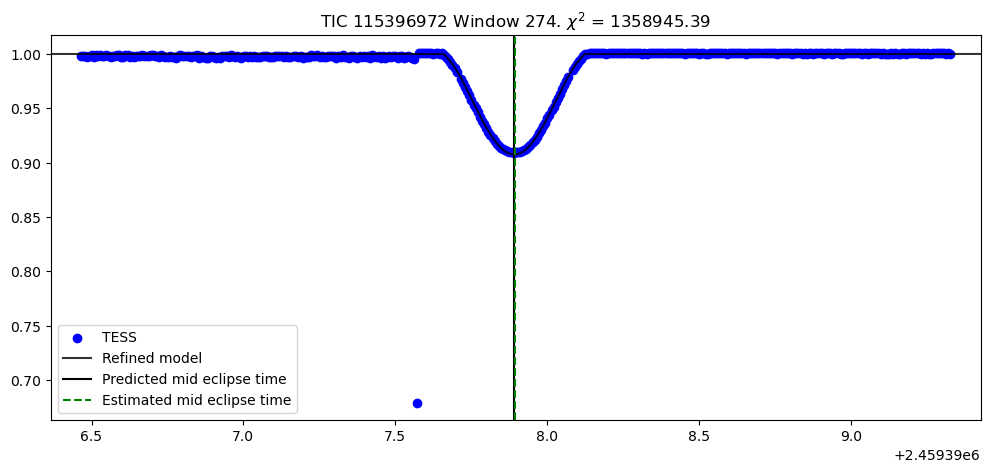

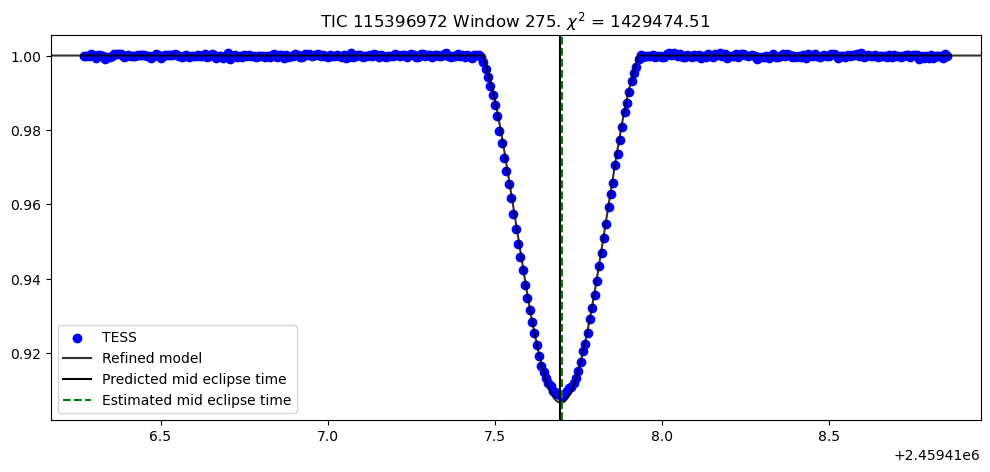

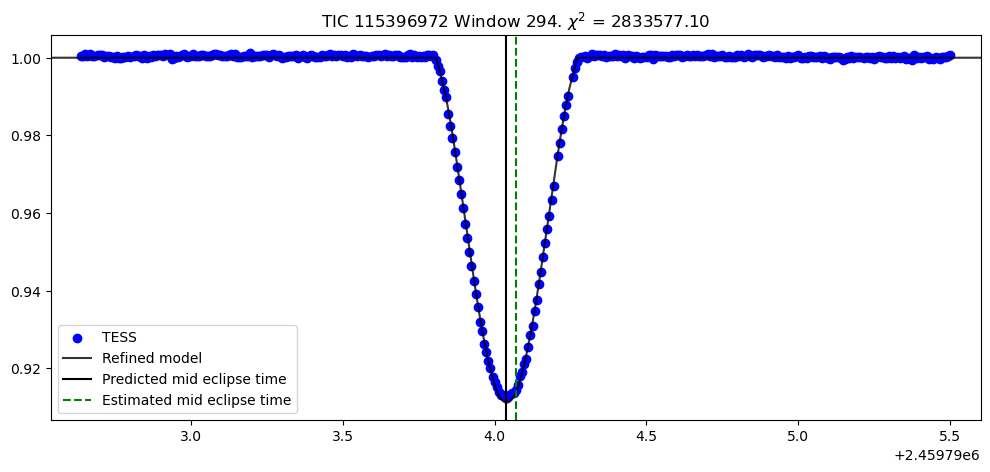

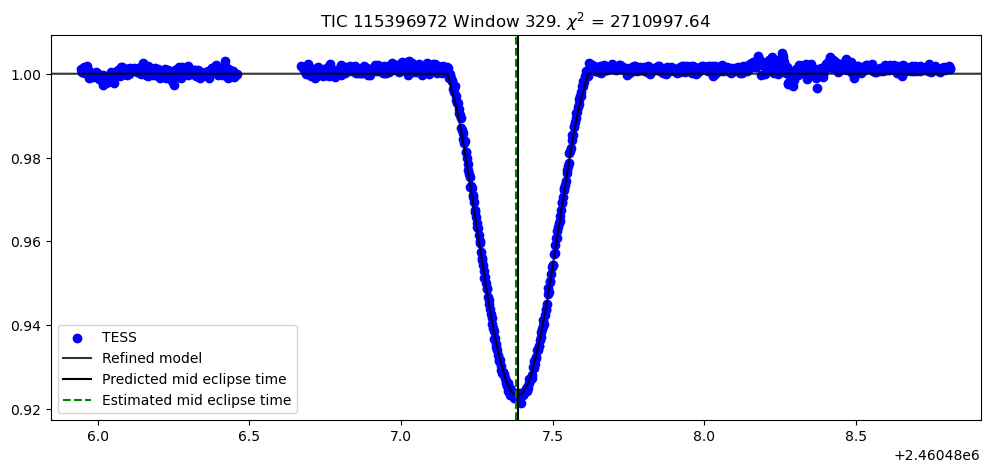

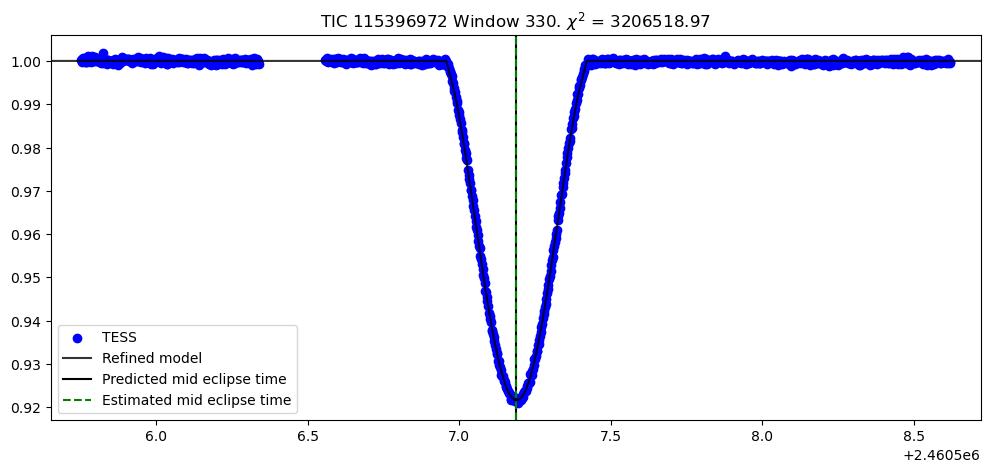

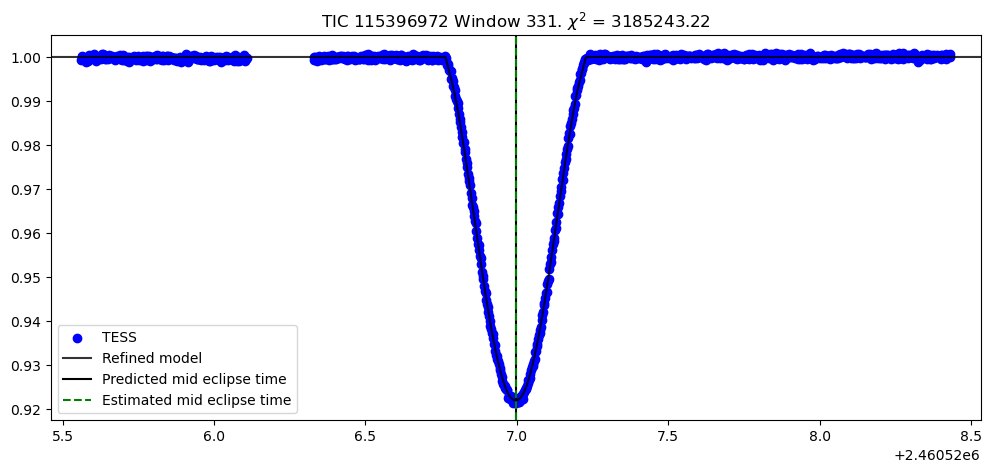

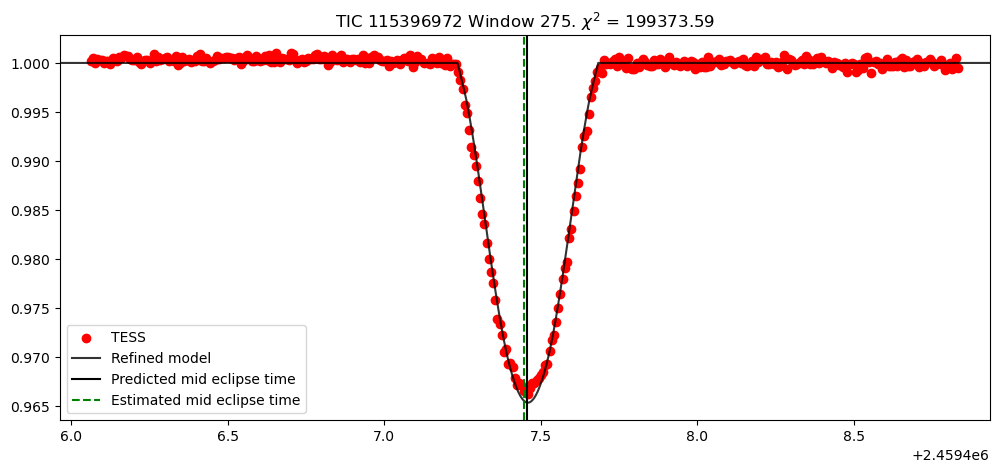

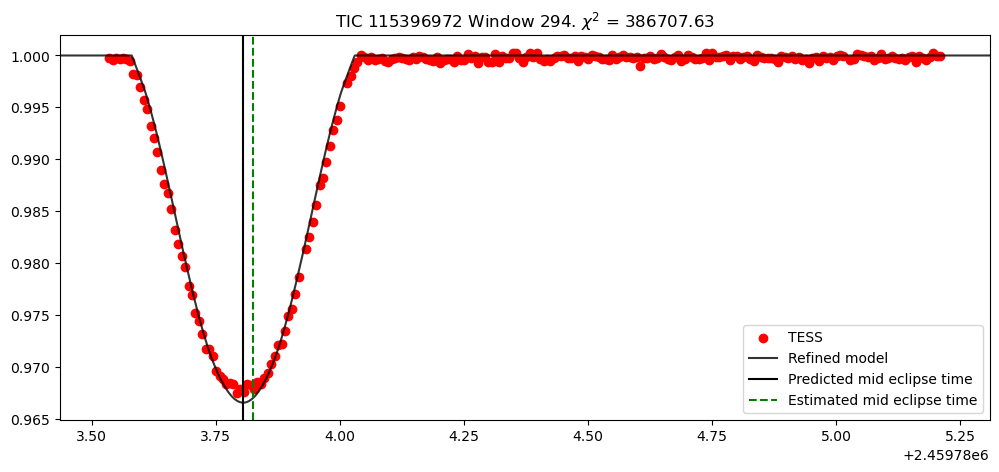

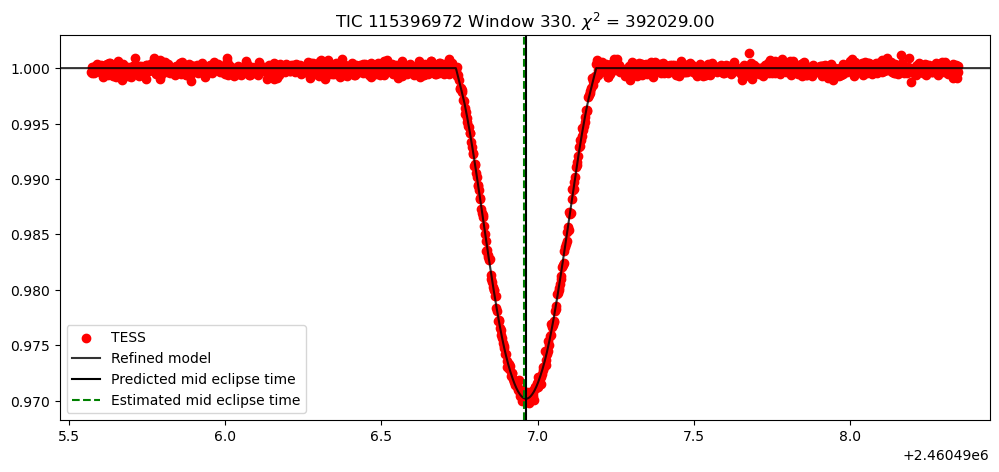

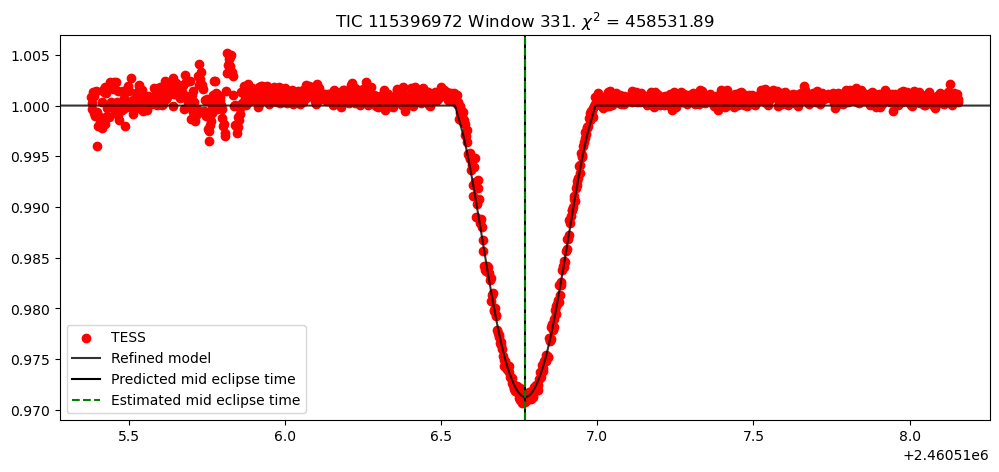

In [20]:
i = 0
lc = lightcurves[i]

# Initialise some lists
p_mets, p_best_chisqs, p_lower_diffs, p_upper_diffs, p_sources = [], [], [], [], []
s_mets, s_best_chisqs, s_lower_diffs, s_upper_diffs, s_sources = [], [], [], [], []

# Load our models, widths, and emets
p_model_flux = primary_models[i]
s_model_flux = secondary_models[i]

p_width = primary_widths[i]
s_width = secondary_widths[i]

p_emets = p_emets_list[i]
s_emets = s_emets_list[i]

# ~~~~~~~~~~~~~~~~~~~~~~~~ Primary windows ~~~~~~~~~~~~~~~~~~~~~~~~ #
for iw, window in enumerate(p_windows_list[i]):
    
    # Run our cross correlation
    met, best_chisq, lower_diff, upper_diff = find_eclipse_optimise(window, p_width, p_model_flux, i, iw, plot=True)

    # Check for any None values
    if None in [met, best_chisq, lower_diff, upper_diff]:
        met = best_chisq = lower_diff = upper_diff = None
        source = None
    else:
        source = window[0]['source']

    # Append our data
    p_mets.append(met)
    p_best_chisqs.append(best_chisq)
    p_lower_diffs.append(lower_diff)
    p_upper_diffs.append(upper_diff)
    p_sources.append(source)

# ~~~~~~~~~~~~~~~~~~~~~~~~ Secondary windows ~~~~~~~~~~~~~~~~~~~~~~~~ #
for iw, window in enumerate(s_windows_list[i]):  
   
    # Run our cross correlation
    met, best_chisq, lower_diff, upper_diff = find_eclipse_optimise(window, s_width, s_model_flux, i, iw, plot=True, eclipse = 'secondary')

    # Check for any None values
    if None in [met, best_chisq, lower_diff, upper_diff]:
        met = best_chisq = lower_diff = upper_diff = None
        source = None
    else:
        source = window[0]['source']

    # Append our data
    s_mets.append(met)
    s_best_chisqs.append(best_chisq)
    s_lower_diffs.append(lower_diff)
    s_upper_diffs.append(upper_diff)
    s_sources.append(source)

Now that we have accurate timings for our eclipses, we can put these into a table together and calculate an OC value, the difference between the observed eclipse time and the expected (or calculated) time.

In [21]:
def create_oc_table(met_list, emet_list, best_chisq_list, lower_diff_list, upper_diff_list, source_list, return_good=True, good_threshold=1000):

    # Calculate OC values
    oc_values = [(m - e)*1440 if m is not None else None for m, e in zip(met_list, emet_list)]

    # Convert errors to minutes
    upper_error_min = [x * 1440 if x is not None else None for x in upper_diff_list]
    lower_error_min = [x * 1440 if x is not None else None for x in lower_diff_list]

    # Create the table
    oc_table = Table([emet_list, met_list, oc_values, upper_error_min, lower_error_min, best_chisq_list, source_list], names=('eMET', 'MET', 'OC', 'upper_error', 'lower_error', 'chisq', 'source'))
    
    if return_good == True:

        # Get rid of None values
        mask = [val is not None for val in oc_table['MET']]
        oc_table = oc_table[mask]

        # Get rid of values below threshold
        mask = [(np.isfinite(val) and val > good_threshold) for val in oc_table['chisq']]
        oc_table = oc_table[mask]

        # Filter based on MAD to remove bad outliers
        
        median = np.nanmedian(oc_table['OC'])
        mad = np.nanmedian(np.abs(oc_table['OC'] - median))
        sigma = 1.4826 * mad
        
        mask = np.abs(oc_table['OC'] - median) < 5 * sigma
        oc_table = oc_table[mask]

        # Centre the OC values on zero at the rightmost edge
        oc_values = np.array(oc_table['OC'])
        oc_table['OC'] = oc_values - oc_values[-1]

        return oc_table

    return oc_table

In [22]:
def plot_oc(p_oc_table, s_oc_table):

    # Help define limits for the plots
    '''Added since they used to be dominated by errorbars'''
    # min_oc = min(np.min(p_oc_table['OC']), np.min(s_oc_table['OC']))
    # max_oc = max(np.max(p_oc_table['OC']), np.max(s_oc_table['OC']))

    
    # Define marker for each source
    marker_map = {
        'TESS': 'o',    # circle
        'WASP': 's',    # square
        'KELT': '^'     # triangle
    }
    
    plt.figure(figsize=(8,5))
    
    # Plot primaries
    for src, marker in marker_map.items():
        mask = p_oc_table['source'] == src
    
        yerr = np.vstack([
            p_oc_table['lower_error'][mask],
            p_oc_table['upper_error'][mask]
        ])
    
        plt.errorbar(
            p_oc_table['MET'][mask],
            p_oc_table['OC'][mask],
            yerr=yerr,
            fmt=marker,
            c='blue',
            capsize=2,
            linestyle='none',
            label=f'Primaries ({src})'
        )
    
    # Plot secondaries
    for src, marker in marker_map.items():
        mask = s_oc_table['source'] == src
    
        yerr = np.vstack([
            s_oc_table['lower_error'][mask],
            s_oc_table['upper_error'][mask]
        ])
    
        plt.errorbar(
            s_oc_table['MET'][mask],
            s_oc_table['OC'][mask],
            yerr=yerr,
            fmt=marker,
            c='red',
            capsize=2,
            linestyle='none',
            label=f'Secondaries ({src})'
        )
    
    plt.ylabel('O-C (minutes)')
    plt.xlabel('Mid Eclipse Times (BJD)')
    plt.axhline(0, c='black')
    # plt.ylim(min_oc*1.1, max_oc*1.1)
    plt.grid()
    plt.legend()
    plt.show()

In [26]:
# Create the OC tables from our lists
p_oc_table = create_oc_table(p_mets, p_emets, p_best_chisqs, p_lower_diffs, p_upper_diffs, p_sources)
s_oc_table = create_oc_table(s_mets, s_emets, s_best_chisqs, s_lower_diffs, s_upper_diffs, s_sources)

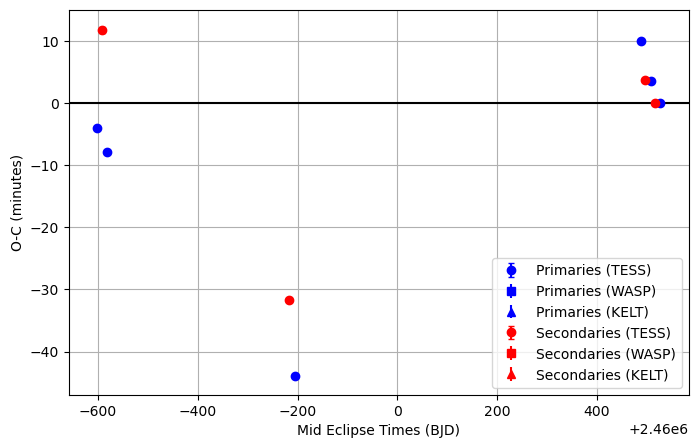

In [27]:
# Create the OC plot
plot_oc(p_oc_table, s_oc_table)

A combination of the table and the plots are our final results here, whjch can be used for further research or improved with more data.